# Clustering Customers by KMeans

Dataset can be found from [here](https://archive.ics.uci.edu/ml/datasets/online+retail). This is a transnational data set which contains all the transactions occurring between **01/12/2010** and **09/12/2011** for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Inserting necessary packages and the dataset.

In [1]:
import pandas as pd
import datetime as dt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
%matplotlib inline
warnings.filterwarnings('ignore')
online = pd.read_excel("Desktop/Online Retail.xlsx")
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Add amount by multiplying **UnitPrice** with **Quantity**

In [2]:
online['Amount'] = online['Quantity'] * online['UnitPrice']
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Since the data is between 01/12/2010 and 09/12/2011 dates, I am assuming that I am making this analysis one day after the last day of this dataset, therefore I am assigning this day to a variable.

In [3]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


**RFM analysis** is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

RECENCY (R): Time since last purchase
FREQUENCY (F): Total number of purchases
MONETARY VALUE (M): Total monetary value

RFM analysis was first used by the direct mail industry more than four decades ago, yet it is still an effective way to optimize your marketing.

In [4]:
# Aggregate data on a customer level
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Amount': 'sum'})
# Rename columns for easier interpretation
datamart.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'Amount': 'MonetaryValue'}, inplace=True)
# Check the first rows
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [5]:
# Recency Labels
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart['R'] = r_quartiles.values
# Frequency Labels
f_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
datamart['F'] = f_quartiles.values
# Monetary Labels
m_labels = range(1,5)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart['M'] = m_quartiles.values
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


In [8]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3.0
12347.0,2,182,4310.00,4,4,4,444,12.0
12348.0,75,31,1797.24,2,2,4,224,8.0
12349.0,19,73,1757.55,3,3,4,334,10.0
12350.0,310,17,334.40,1,1,2,112,4.0


RFM score and segment values are ready, now I am going to implement KMeans clustering. However, in order to use KMeans method, we need to satisfy its assumptions.

**Key k-means assumptions**
- Symmetric distribution of variables (not skewed)
- Variables with same average values
- Variables with same variance

Starting with removing negative values and then applying log transform for skewness.

In [10]:
# Remove Negative Values
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]

datamart_rfm = datamart_rfm[(datamart_rfm['Recency']>0) 
                            & (datamart_rfm['Frequency']>0) 
                            & (datamart_rfm['MonetaryValue']>0)]
np.sum((datamart_rfm <= 0).values.ravel())

0

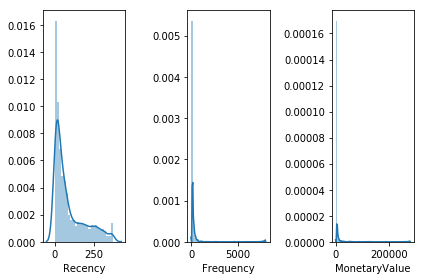

In [11]:
fig, ax =plt.subplots(1,3)
sns.distplot(datamart_rfm['Recency'], ax=ax[0])
sns.distplot(datamart_rfm['Frequency'], ax=ax[1])
sns.distplot(datamart_rfm['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In order to prevent failure from skewness assumption, I am going to use logarithmic transformation. One should consider before using log transformation, it works only with positive values, one should use another technique if the data has negative values.

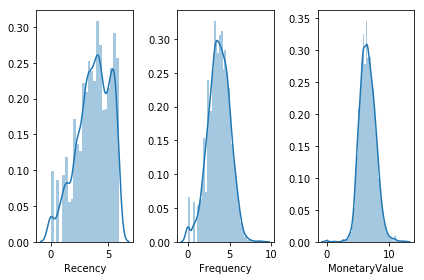

In [12]:
datamart_log = np.log(datamart_rfm.round(3))
# Replacing infinite and NaN values with 0 (due to log(0))
datamart_log = datamart_log.replace([np.inf, -np.inf, np.NaN], 0)

fig, ax = plt.subplots(1,3)
sns.distplot(datamart_log['Recency'], ax=ax[0])
sns.distplot(datamart_log['Frequency'], ax=ax[1])
sns.distplot(datamart_log['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

Descriptive statistics before scaling

In [13]:
datamart_log.describe().round(3)

,Recency,Frequency,MonetaryValue
count,4322.000,4322.000,4322.000
mean,3.716,3.714,6.562
std,1.461,1.314,1.266
min,0.000,0.000,0.000
25%,2.833,2.890,5.711
50%,3.902,3.738,6.489
75%,4.927,4.632,7.394
max,5.924,8.985,12.541


Descriptive statistics after scaling, mean = 0 and std = 1

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_log)
datamart_normalized = scaler.transform(datamart_log)
print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [-0.  0. -0.]
std:  [1. 1. 1.]


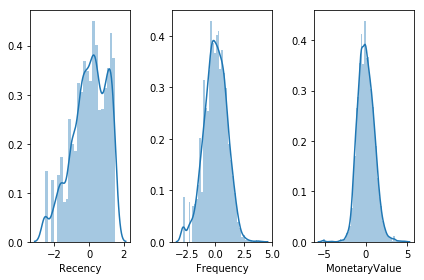

In [15]:
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)
fig, ax = plt.subplots(1,3)
sns.distplot(datamart_normalized['Recency'], ax=ax[0])
sns.distplot(datamart_normalized['Frequency'], ax=ax[1])
sns.distplot(datamart_normalized['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

Now the dataset is ready, I am starting to implement KMeans.

I am going to use Elbow method to identify which number of clusters would be ideal to use.

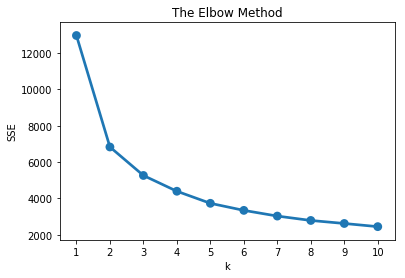

In [16]:
# Import key libraries
from sklearn.cluster import KMeans

 # Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

It looks like it would be better to use 3 clusters.

In [17]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters = 3, random_state = 1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          67.4      67.3        1069.0  1836
1         169.2      15.5         281.7  1506
2          12.2     264.9        6047.3   980

Snake plots to understand and compare segments
- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Need to first normalize data (center & scale)
- Plot each cluster's average normalized values of each attribute

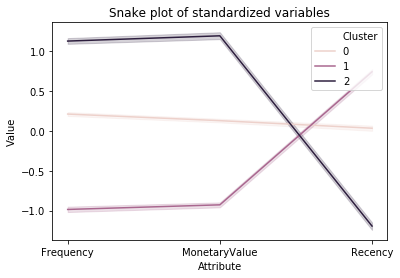

In [18]:
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

# Melt the data into a long format so RFM values and metric names are stored in 1 column each
datamart_melt = pd.melt(datamart_normalized.reset_index(), 
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                    var_name='Attribute', 
                    value_name='Value')

plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)
plt.show()

Relative importance of segment attributes
- Useful technique to identify relative importance of each segment's attribute
- Calculate average values of each cluster
- Calculate average values of population
- Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

In [21]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()
population_avg = datamart_rfm.mean()
relative_imp = cluster_avg / population_avg - 1

relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.25,-0.28,-0.44
1,0.87,-0.84,-0.85
2,-0.86,1.82,2.14


Analyze and plot relative importance
- The further a ratio is from 0, the more important that attribute is for a segment relative to the total population.

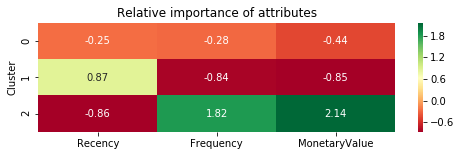

In [22]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

End of the notebook.